Imports

In [22]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from skimage import filters
from scipy import ndimage
from skimage.measure import block_reduce
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [3]:
def block_calc_2D(in_shp, trgt_shp):
    return int(in_shp[0]/trgt_shp[0]), int(in_shp[1]/trgt_shp[1])

In [4]:
def plt_fun(arr, title, size=(10,10)):
    plt.figure(figsize=size)
    plt.imshow(arr)
    plt.title(title)
    plt.show()

Load Image

In [5]:
path = r'.\data\Well2_100min_XY1_EGFP_10X.tif'
img = Image.open(path)
img_arr = np.array(img)

path = r'.\data\Well2_100min_XY1_DAPI_10X.tif'
img = Image.open(path)
dapi_arr = np.array(img)

path = r'.\data\Well2_100min_XY1_CY5_10X1.tif'
img = Image.open(path)
cy5_arr = np.array(img)


Subtraction refers to middle section to be subtracted out of calculations from dapi stain

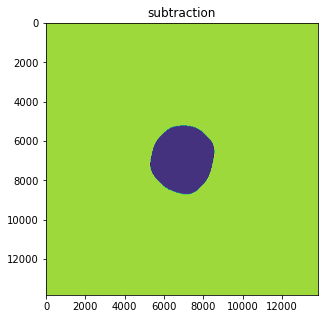

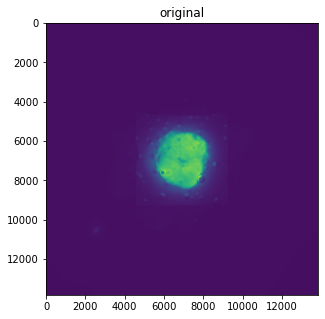

In [6]:
orig_size = dapi_arr.shape
subtraction = cv2.resize(dapi_arr, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
subtraction = ndimage.gaussian_filter(subtraction, 10)
subtraction = subtraction/np.max(subtraction)*100
subtraction[subtraction < 50] = 0
subtraction[subtraction >= 50] = 1
subtraction = ndimage.binary_dilation(subtraction.astype(np.uint8), iterations=10)
subtraction = 1 - subtraction
subtraction = cv2.resize(subtraction.astype(np.float), dsize=orig_size, interpolation=cv2.INTER_CUBIC)

plt_fun(subtraction, "subtraction", size=(5,5))
plt_fun(dapi_arr, "original", size=(5,5))

The below section adaptively subtracts out background

In [7]:
#img_arr = np.multiply(img_arr, subtraction)
new_arr = np.zeros_like(img_arr)

sample_area = 100
s_len = int(sample_area/2)
for i in range(s_len,img_arr.shape[0], sample_area):
    for j in range(s_len,img_arr.shape[1], sample_area):
        curr_area = img_arr[i-s_len:i+s_len, j-s_len:j+s_len]
        background = np.percentile(curr_area, 0.5)
        curr_area = curr_area - background
        curr_area[curr_area < 0] = 0
        new_arr[i-s_len:i+s_len, j-s_len:j+s_len] = curr_area
    print(f"Processing {i/img_arr.shape[0]:.2%}", end='\r')

# don't want to normalize because wanna see time variance?
#egfp_arr = np.multiply(new_arr, subtraction)/np.max(new_arr)*255
egfp_arr = np.multiply(new_arr, subtraction)


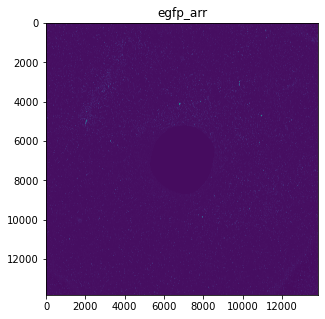

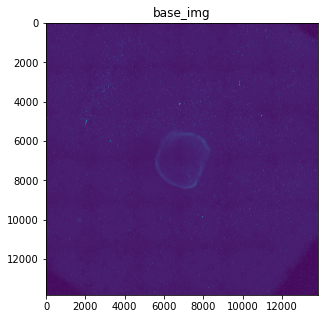

In [8]:
plt_fun((egfp_arr/np.max(egfp_arr)*255), "egfp_arr", size=(5,5))
plt_fun(img_arr, "base_img", size=(5,5))

Remove low-brightness noise and invert object brightness

In [9]:
#filtered_labels[filtered_labels > 0] = 255
cv2.imwrite("egfp_arr.png", egfp_arr, [cv2.IMWRITE_PNG_COMPRESSION, 0])


True

In [10]:
def normalize255(img):
    return img/np.max(img)*255

def normalize1(img):
    return (img/np.max(img)).astype(np.float)

Try Using Entropy

In [11]:
filtered_arr = normalize255(np.array(egfp_arr[3000:3500, 3000:3500]))
filtered_arr[filtered_arr < 3] = 0
filtered_arr = normalize1(filtered_arr)
entr_img = normalize1(entropy(filtered_arr, disk(3)))

filtered_arr = cv2.merge([filtered_arr, filtered_arr, filtered_arr])
entr_img = cv2.merge([np.zeros_like(entr_img), entr_img, np.zeros_like(entr_img)])

added_image = cv2.addWeighted(filtered_arr,1,entr_img,0.3,0)

%matplotlib auto
#plt_fun(added_image, "added", size=(10,10))
plt_fun(filtered_arr, "orig", size=(10,10))
plt_fun(entr_img, "entropy", size=(10,10))

C:\Users\Alec_\anaconda3\envs\MacVis2\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


Using matplotlib backend: Qt5Agg


Try Using simple thresholding

In [27]:
filtered_arr = normalize255(np.array(egfp_arr))
filtered_arr[filtered_arr < 6] = 0
filtered_arr[filtered_arr > 30] = 0

%matplotlib auto

plt_fun(np.array(egfp_arr[3000:3500, 3000:3500]), "orig", size=(10,10))
plt_fun(filtered_arr[3000:3500, 3000:3500], "filtered", size=(10,10))




Using matplotlib backend: Qt5Agg


In [29]:
sum_arr = filtered_arr
sum_arr[sum_arr > 0] = 1
area_calc = block_reduce(sum_arr, (100,100), np.sum)

plt_fun(area_calc, "summed", size=(10,10))